In [1]:
import pymc as pm
import graphviz
import matplotlib.pyplot as plt
import pandas as pd



WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


In [2]:
def plot_model_graph(model):
    """
    Gera o grafo do modelo Bayesiano definido no PyMC.
    
    Parâmetros:
        model (pm.Model): Modelo PyMC definido.
    
    Retorna:
        graphviz.Source: Objeto do grafo do modelo.
    """
    return pm.model_to_graphviz(model)

In [3]:
data = pd.read_csv("../data/JOAO PESSOA.csv")


In [4]:
data

,Data da Coleta,Produto,Valor de Venda
0,2018-12-30,GASOLINA,4.184500
1,2019-01-06,GASOLINA,4.063250
2,2019-01-13,GASOLINA,4.028167
3,2019-01-20,GASOLINA,3.952458
4,2019-01-27,GASOLINA,3.903375
...,...,...,...
309,2024-12-01,GASOLINA,5.861579
310,2024-12-08,GASOLINA,5.853684
311,2024-12-15,GASOLINA,5.841053
312,2024-12-22,GASOLINA,5.846842


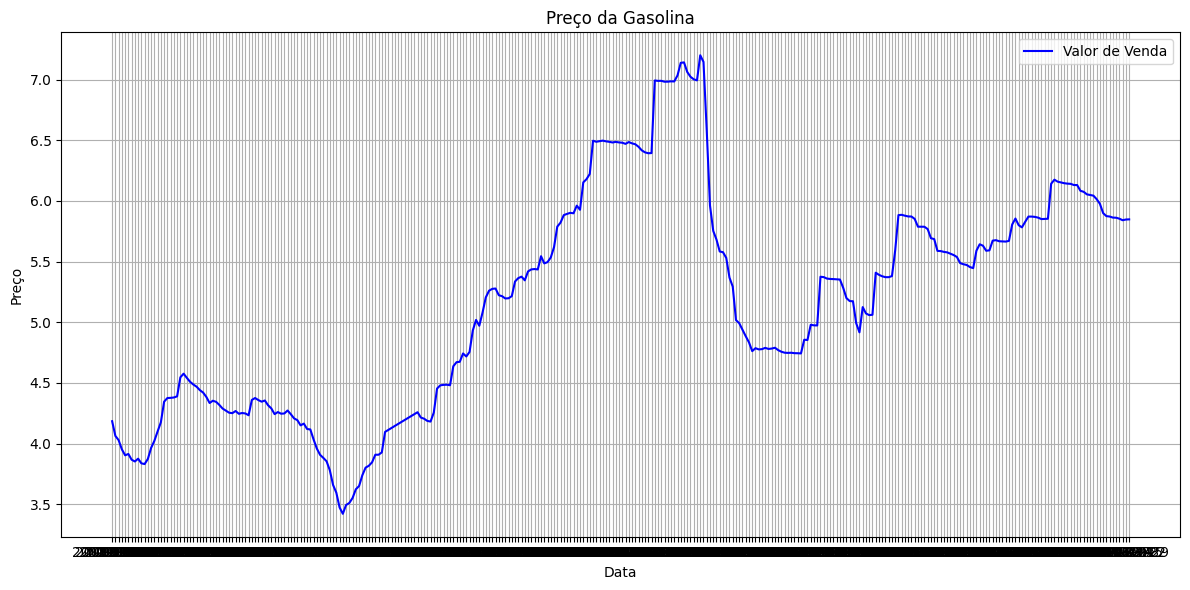

In [5]:

# Renomeando a coluna
data.rename(columns={'Valor de Venda': 'Valor_de_Venda'}, inplace=True)
data = data.drop(columns='Produto')
data.set_index('Data da Coleta', inplace=True)

from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=1)

data['Valor_de_Venda'].interpolate(method='linear', inplace=True)  # Interpola linearmente


plt.figure(figsize=(12,6))
plt.plot(data.index, data['Valor_de_Venda'], color='blue', label='Valor de Venda')

# Títulos e legendas
plt.title('Preço da Gasolina')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [6]:
data

,Valor_de_Venda
Data da Coleta,
2018-12-30,4.184500
2019-01-06,4.063250
2019-01-13,4.028167
2019-01-20,3.952458
2019-01-27,3.903375
...,...
2024-12-01,5.861579
2024-12-08,5.853684
2024-12-15,5.841053


In [7]:
# Ordenar por tempo
data = data.sort_values("Data da Coleta")

# Criar variável lag1
data["lag1"] = data["Valor_de_Venda"].shift(1)
data = data.dropna()  # Remover primeira linha com NaN

# Divisão em treino e teste (80% treino, 20% teste)
train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]



In [8]:
# Definir variáveis para treino
X_train = train_data["lag1"].values
y_train = train_data["Valor_de_Venda"].values

print("tamanho do conjunto de treinamento :",len(X_train))

tamanho do conjunto de treinamento : 250


In [9]:
# Obter os valores do conjunto de teste
X_test = test_data["lag1"].values
y_test = test_data["Valor_de_Venda"].values

print("tamanho do conjunto de teste:",len(X_test))

tamanho do conjunto de teste: 63


In [10]:
import statsmodels.api as sm
import numpy as np

# Adicionar intercepto para estimar alpha
X_train_const = sm.add_constant(X_train)  

# Ajustar modelo de regressão linear
modelo_ols = sm.OLS(y_train, X_train_const).fit()

# Obter estimativas dos coeficientes
alpha_hat = modelo_ols.params[0]  # Intercepto (alpha)
beta_hat = modelo_ols.params[1]   # Coeficiente do lag (beta)

# Obter desvio padrão dos coeficientes
alpha_std = modelo_ols.bse[0]
beta_std = modelo_ols.bse[1]

# Estimar sigma (desvio padrão dos resíduos)
sigma_hat = modelo_ols.resid.std()

print(f"Alpha: média = {alpha_hat:.4f}, desvio padrão = {alpha_std:.4f}")
print(f"Beta: média = {beta_hat:.4f}, desvio padrão = {beta_std:.4f}")
print(f"Sigma: média = {sigma_hat:.4f}")


Alpha: média = 0.0351, desvio padrão = 0.0341
Beta: média = 0.9943, desvio padrão = 0.0067
Sigma: média = 0.0995


## Ajsute 

* Sugerir media zero, variancia grande.(como nao há parametros sugeridos por especialistas).  
Ao sugerir dados de uma regressão eu envieso o modelo, pois passo duas vezes os dados para o modelo.

## Ajuste

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 1243 seconds.
Sampling: [alpha, beta, sigma]


Output()

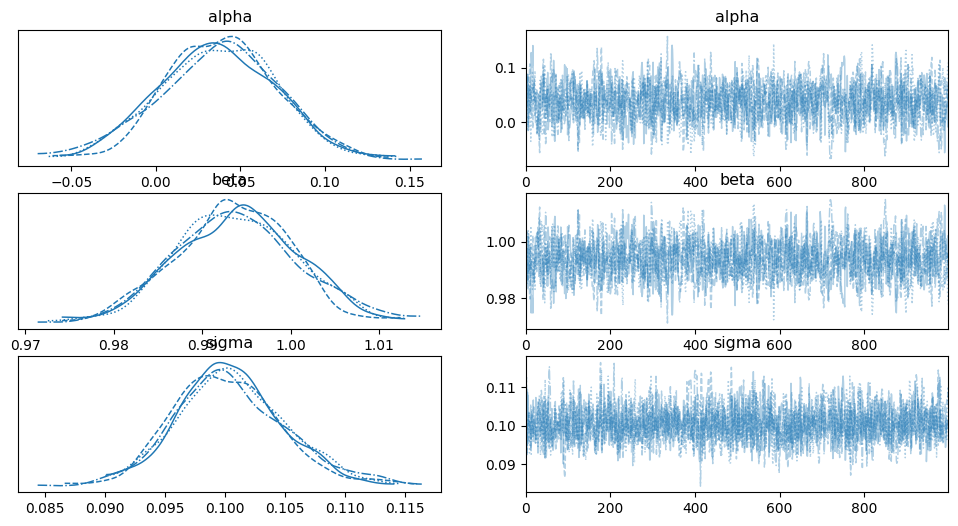

In [11]:
import numpy as np
import arviz as az
from sklearn.metrics import mean_absolute_error, mean_squared_error

'''
Mudar os valores de mu e sigma em cada distribuição normal
Estudar a série para definir melhores valores nessas distribuições
Manter as médias próximas de zero
'''

# Ajustando as coordenadas para PyMC
coords = {"tempo": train_data.index.values}  # Usar o índice do DataFrame

# Criar modelo Bayesiano com lag no conjunto de treino
with pm.Model(coords=coords) as modelo:
    alpha = pm.Normal("alpha", mu=0, sigma=2)  
    beta = pm.Normal("beta", mu=0, sigma=2)  
    sigma = pm.HalfNormal("sigma", sigma=1)  

    mu = alpha + beta * X_train
    precos = pm.Normal("precos", mu=mu, sigma=sigma, observed=y_train, dims="tempo")

    trace = pm.sample(1000, tune=500, target_accept=0.8, random_seed=42)

# Analisar resultados
az.plot_trace(trace, var_names=["alpha", "beta", "sigma"])
az.summary(trace, var_names=["alpha", "beta", "sigma"])

# --------------- Avaliação no Conjunto de Teste ---------------

# Criar previsões para o conjunto de teste
with modelo:
    idata_pred = pm.sample_posterior_predictive(trace, var_names=["alpha", "beta", "sigma"], random_seed=42)

# Obter amostras de alpha e beta do trace
alpha_samples = trace.posterior["alpha"].values  # (chains, draws)
beta_samples = trace.posterior["beta"].values  # (chains, draws)

# Redimensionar para aplicar corretamente aos dados de teste
alpha_samples = alpha_samples.reshape(-1, 1)  # (n_amostras, 1)
beta_samples = beta_samples.reshape(-1, 1)  # (n_amostras, 1)



In [17]:
import os
os.environ["PATH"] += os.pathsep + r"C:\Program Files\Graphviz\bin"


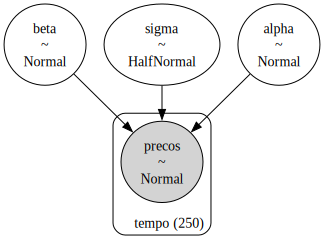

In [18]:
plot_model_graph(modelo)

NUTS (No-U-Turn Sampler): Uma variante do HMC que evita trajetórias muito longas ou curtas ao explorar o espaço de parâmetros.
HMC (Hamiltonian Monte Carlo): Em vez de caminhar aleatoriamente como no Metropolis-Hastings, ele usa derivadas (gradientes) da função de verossimilhança para explorar o espaço de forma mais eficiente.
Benefício do NUTS: Reduz correlação entre amostras, converge mais rápido e precisa de menos ajuste manual.

In [13]:
# Previsão incremental para cada ponto no tempo
y_pred_incremental = []

for t in range(len(X_test)):
    x_t = X_test[t]  # Apenas o instante t
    
    # Gerar previsão com amostras de alpha e beta
    y_pred_t_samples = alpha_samples + beta_samples * x_t
    
    # Tirar a média das amostras para obter uma única previsão
    y_pred_t = np.mean(y_pred_t_samples)
    
    # Armazena a previsão
    y_pred_incremental.append(y_pred_t)


In [14]:
# Calcular métricas de desempenho
mae = mean_absolute_error(y_test, y_pred_incremental)
mse = mean_squared_error(y_test, y_pred_incremental)
rmse = np.sqrt(mse)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")


MAE: 0.0280
MSE: 0.0028
RMSE: 0.0527


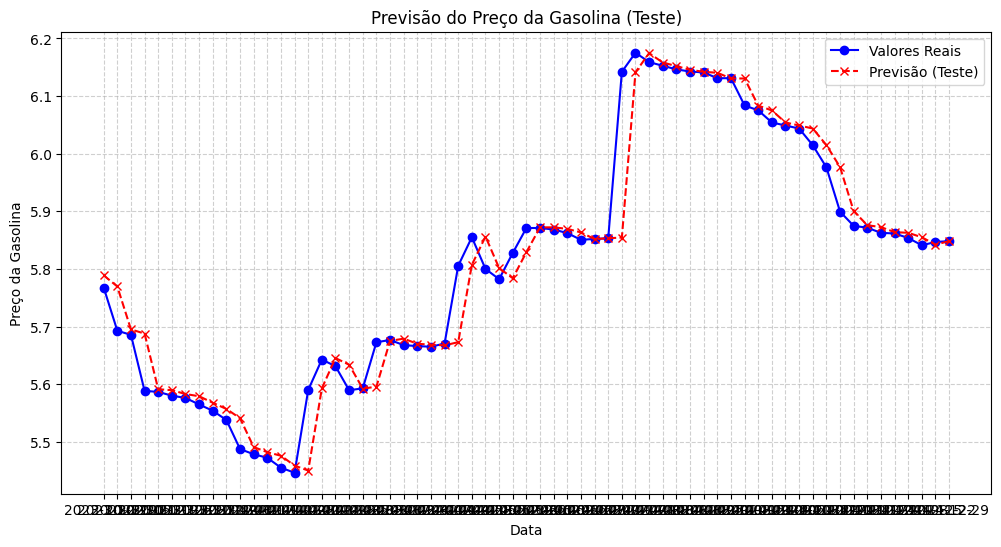

In [30]:
plt.figure(figsize=(12, 6))

# Plotar os valores reais usando o índice do DataFrame
plt.plot(test_data.index, test_data["Valor_de_Venda"], label="Valores Reais", marker="o", color="blue")

# Plotar as previsões APENAS no conjunto de teste
plt.plot(test_data.index, y_pred_incremental, label="Previsão (Teste)", linestyle="--", color="red", marker="x")

# Personalizar o eixo X para evitar sobreposição de rótulos
plt.xlabel("Data")
plt.ylabel("Preço da Gasolina")
plt.title("Previsão do Preço da Gasolina (Teste)")
plt.legend()


plt.grid(True, linestyle="--", alpha=0.6)  # Melhorar a visibilidade do grid

# Mostrar gráfico
plt.show()


